<a href="https://colab.research.google.com/github/Dhaneesh02/fyp_SER/blob/mfcc/mfcc_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
import os
from glob import glob
import pickle
import numpy as np

### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3225, 5, 128, 128)
(3225,)
(807, 5, 128, 128)
(807,)


In [ ]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

In [ ]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [ ]:
X_train.shape[1:]

(5, 128, 128, 1)

In [ ]:
K.clear_session()

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                                           
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_MELSPECT (InputLayer)  [(None, 5, 128, 128, 1)]  0        
                                                                 
 Conv_1_MELSPECT (TimeDistri  (None, 5, 128, 128, 64)  640       
 buted)                                                          
                                                                 
 BatchNorm_1_MELSPECT (TimeD  (None, 5, 128, 128, 64)  256       
 istributed)                                                     
                                                                 
 Activ_1_MELSPECT (TimeDistr  (None, 5, 128, 128, 64)  0         
 ibuted)                                                         
                                                                 
 MaxPool_1_MELSPECT (TimeDis  (None, 5, 64, 64, 64)    0         
 tributed)                                                   

In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('CNN_LSTM_Model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save,tf.keras.callbacks.CSVLogger('drive/My Drive/FYP/Pickle/source_history.csv')])

Epoch 1/100
51/51 [==============================] - 59s 868ms/step - loss: 1.9319 - accuracy: 0.1820 - val_loss: 2.0615 - val_accuracy: 0.1710
Epoch 2/100
51/51 [==============================] - 39s 771ms/step - loss: 1.8186 - accuracy: 0.2502 - val_loss: 1.9758 - val_accuracy: 0.2082
Epoch 3/100
51/51 [==============================] - 39s 773ms/step - loss: 1.7118 - accuracy: 0.3129 - val_loss: 1.9082 - val_accuracy: 0.2900
Epoch 4/100
51/51 [==============================] - 39s 772ms/step - loss: 1.6392 - accuracy: 0.3473 - val_loss: 1.9544 - val_accuracy: 0.2255
Epoch 5/100
51/51 [==============================] - 39s 771ms/step - loss: 1.6001 - accuracy: 0.3584 - val_loss: 1.8722 - val_accuracy: 0.2379
Epoch 6/100
51/51 [==============================] - 39s 772ms/step - loss: 1.5559 - accuracy: 0.3805 - val_loss: 1.7187 - val_accuracy: 0.2900
Epoch 7/100
51/51 [==============================] - 39s 774ms/step - loss: 1.5395 - accuracy: 0.3910 - val_loss: 1.5849 - val_accuracy:

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
y_pred=model.predict(X_test)
y_classes = y_pred.argmax(axis=-1)

In [ ]:
np.unique(y_classes)

In [ ]:
my_dict={}

In [ ]:
np.vectorize(my_dict.get)(a)

In [ ]:
model.save('drive/My Drive/Pickle/[CNN-LSTM]M.h5')
model.save_weights('drive/My Drive/Pickle/[CNN-LSTM]W.h5')

In [ ]:
# unaugmented_model = tf.keras.models.load_model('/content/drive/MyDrive/Pickle/unaugmented[CNN-LSTM]M.h5')
# unaugmented_model.load_weights('/content/drive/MyDrive/Pickle/unaugmented[CNN-LSTM]M.h5')

In [ ]:
# loss, acc = new_model.evaluate(x_test, y_test, verbose=0)
# print(f"test accuracy {acc*100}")

Text(0, 0.5, 'Accuracy')

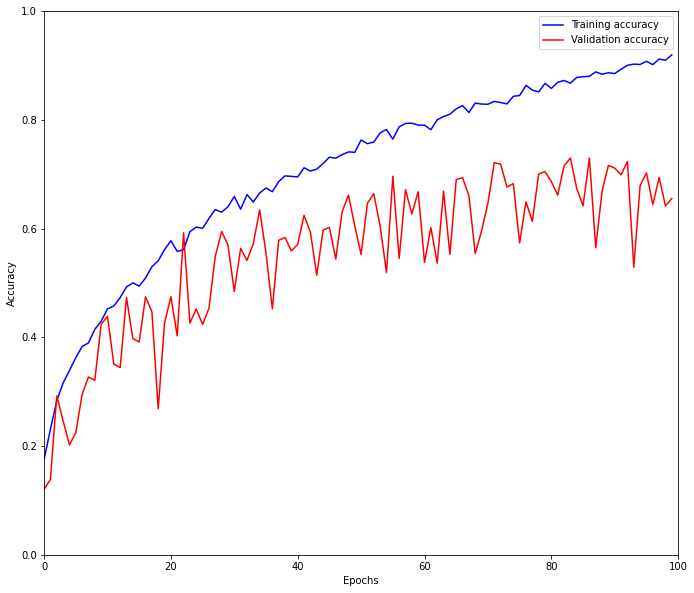

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],'-b')
plt.plot(history.history['val_accuracy'],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

